# NLP unique words feature engineering

An [initial feature engineering notebook](https://github.com/jcarterlab/NLP-initial-feature-engineering/blob/main/nlp_initial_feature_engineering.ipynb) for a Kaggle [student essay scoring competition](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2) suggested somewhat suprisingly a negative correlation between unique words and essay score. This notebook shows how misspelled words significantly contributed to that result. It also outlines how using a fixed number of words can prevent multicollinearity with other features.

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('data/train.csv')
train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


## Calculate unique words

In [2]:
import re
import string
from spellchecker import SpellChecker


continents = [
    'America', 'Europe', 'Africa', 'Asia', 'Oceania', 'America',
    'European', 'African', 'Asian'
]

planets = [
    'Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 
    'Uranus', 'Neptune'
]

temperature_measures = [
    'Celsius', 'Fahrenheit'
]

months = [
  'January', 'February', 'March', 'April', 'May', 'June',
  'July', 'August', 'September', 'October', 'November', 'December'
]

weekdays = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 
    'Sunday'
]

major_wars = [
    'WWI', 'WWII'
]

car_brands = [
  'Ford', 'Toyota', 'Prius', 'Chevrolet', 'Honda', 'Nissan',
  'Hyundai', 'Kia', 'Jeep', 'Ram Trucks', 'GMC',
  'Mercedes-Benz', 'BMW', 'Volkswagen', 'Mazda', 'Lexus',
  'Dodge', 'Audi', 'Subaru', 'Cadillac', 'Chrysler'
]

capital_cities = [
  'London', 'Paris', 'Tokyo', 'New Delhi', 'Berlin', 'Rome',
  'Washington', 'Ottawa', 'Madrid', 'Brasilia',
  'Seoul', 'Beijing', 'Canberra', 'Mexico City', 'Buenos Aires',
  'Cairo', 'Pretoria', 'Kuala Lumpur', 'Singapore', 'Moscow',
  'Jakarta', 'Ankara', 'Jerusalem', 'Abu Dhabi', 'Riyadh',
  'Vienna', 'Stockholm', 'Copenhagen', 'Oslo', 'Dublin'
]

tech_terms = [
    'driverless', 'NASA', 'GPS', 'Google', 'Sergey', 'Brin', 
    'Google', 'tech', 'Meta', 'Netflix', 'PayPal', 'NVIDIA',
    'Tencent', 'Intel', 'TV', 'Huawei', 'Sony'
]

wordtypes = [
    'continents', 'planets', 'temperature_measures','months', 
    'weekdays', 'major_wars', 'car_brands', 'capital_cities',
    'tech_terms'
]


words_list = []
exclusion_list = []
for wordtype in wordtypes:
    words_list.extend(eval(wordtype))


# creates a spellchecker object
spell = SpellChecker()


# drops misspelled words
def drop_mispellings(text):

    # splits the text into words
    words = text.split(' ')
    updated_words = []

    # only keeps words in the exlcusion list or known to spellchecker
    for word in words:
        if word.title() in exclusion_list:
            updated_words.append(word.lower())
        elif spell.known([word]):
            updated_words.append(word.lower())
                    
    return updated_words


# returns the ratio of unique words
def unique_words(text):

    # drops mispellings
    text = drop_mispellings(text)

    # unique words
    unique_words_count = len(set(text))

    # unique words ratio
    unique_words_ratio = unique_words_count / len(text)

    return unique_words_count


train['initial metric'] = [len(set(x.split(' '))) / len(x.split(' ')) for x in train['full_text']]
train['misspellings dropped'] = [unique_words(x) for x in train['full_text']]

## Examine correlation

Dropping misspelled words has reversed the correlation from negative to positive. Yet 0.64 seems suspiciously high, potentially warranting further investigation. 

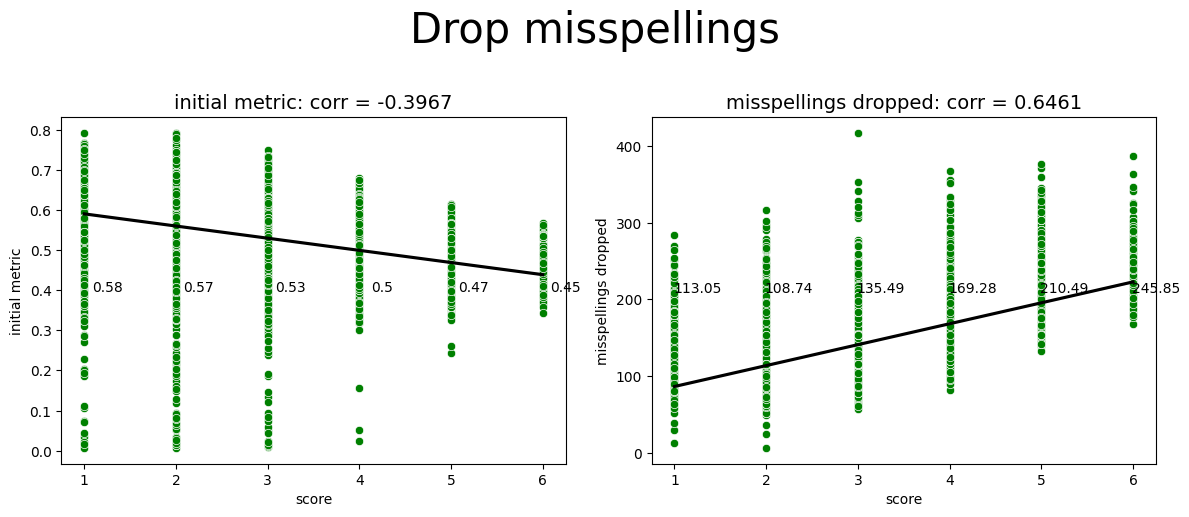

In [3]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# returns whether a set of values largely rise or fall in a linear fashion
def linear(values):
    current = 0 
    positive = []
    negative = []
    for val in values:
        if val > current:
            positive.append(True)
            negative.append(False)
            current = val 
        else:
            positive.append(False)
            negative.append(True)
            current = val 
                
    return (sum(positive)>=5) or (sum(negative)>=4)


# defines y for use in a scatterplot below
y = train['score']


# analyses the relationship between set of features and the y variable
def correlation_analysis(data, var, ncols=3, height=4, title=None):

    # creates a subplot object for use below
    row_num = int(np.ceil(len(var) / 3))
    fig, ax = plt.subplots(nrows=row_num, ncols=ncols, figsize=(12, row_num * height))
    ax = ax.flatten()

    # loops through the variable in question 
    for i, x in enumerate(var):
    
        # calculates an average value of the feature at each score level (1-6)
        avg_x = data.groupby('score')[x].mean().reset_index().iloc[:,1]
    
        # determines the correlation of the feature to y
        corr = round(stats.pearsonr(data[x], y)[0], 4)
    
        # determines whether relationship to score is largely linear or not
        linear_trend = linear(avg_x)
    
        # changes the color based on whether it might be useful to the model or not
        if (abs(corr) >= 0.04) and (linear_trend==True):
            color = 'green'
        else:
            color = 'red'
    
        # creates a scatterplot for each feature
        sns.scatterplot(x=y, y=data[x], ax=ax[i], color=color);
        sns.regplot(x=y, y=data[x], ax=ax[i], scatter=False, color='black');
        ax[i].set_title(x + ': corr = ' + str(round(stats.pearsonr(data[x], y)[0], 4)), size=14);
        
        # adds numerical labels for average value of the feature at each score level (1-6)
        for j, tick in enumerate(avg_x):
            ax[i].text(j+1.25, max(data[x]) / 2, str(round(tick,2)), color='black', ha='center')

    if title == None:
        title = 'Correlation with score'

    plt.suptitle(title, fontsize=30, y=1.025);
    plt.tight_layout();
    plt.show();


# creates an iterable feature list
features = ['initial metric', 'misspellings dropped']


# examines the correlations
correlation_analysis(train, features, ncols=2, height=5, title='Drop misspellings')

## Examine multicollinearity

After examining the correlation between total words (a feature engineered in [another notebook](https://github.com/jcarterlab/NLP-initial-feature-engineering/blob/main/nlp_initial_feature_engineering.ipynb)) and our new unique words feature (0.38), it seems likely that at least some of the new feature's relationship with score is because higher scoring essays tend to be longer and longer essays also tend to have a greater number unique words. 

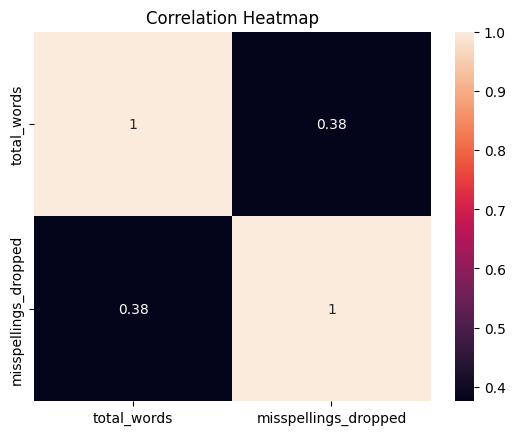

In [4]:
# creates a total words feature as used in another notebook
total_words = [len(x.split(' ')) for x in train['full_text']]

# correlation dataframe
corr_df = pd.DataFrame({'total_words': total_words,
                        'misspellings_dropped': train['misspellings dropped']})

# matrix
correlation_matrix = corr_df.corr()


# heatmap
sns.heatmap(correlation_matrix, annot=True);
plt.title("Correlation Heatmap");
plt.show();

## Find min essay length

To account for this, we can calculate the unique words ratio using a fixed number of words. But we should first consider the minimum essay length.

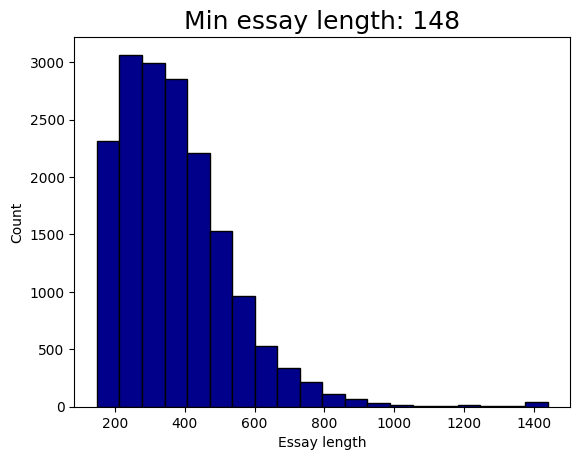

In [5]:
# plots the word length distribution
def trim(data, trim=3):
    mean, std_dev = np.mean(data), np.std(data)
    lower_bound, upper_bound = mean - trim * std_dev, mean + trim * std_dev
    trimmed_data = [x if lower_bound <= x <= upper_bound else (lower_bound if x < lower_bound else upper_bound) for x in data]
    return trimmed_data

essay_len = [len(x.split(' ')) for x in train['full_text']]
min_text_len = min(essay_len)

plt.hist(trim(essay_len), bins=20, color='darkblue', edgecolor='black');
plt.xlabel('Essay length');
plt.ylabel('Count');
plt.title('Min essay length: ' + str(min_text_len), size=18);
plt.show();

## Experiment with word no.

Experimenting with different numbers of word shows us that using the first 60 words of each essay should provide a more realistic and useful feature.

Working on range: 50
Working on range: 100
Working on range: 150
Working on range: 200
Working on range: 250
Working on range: 300


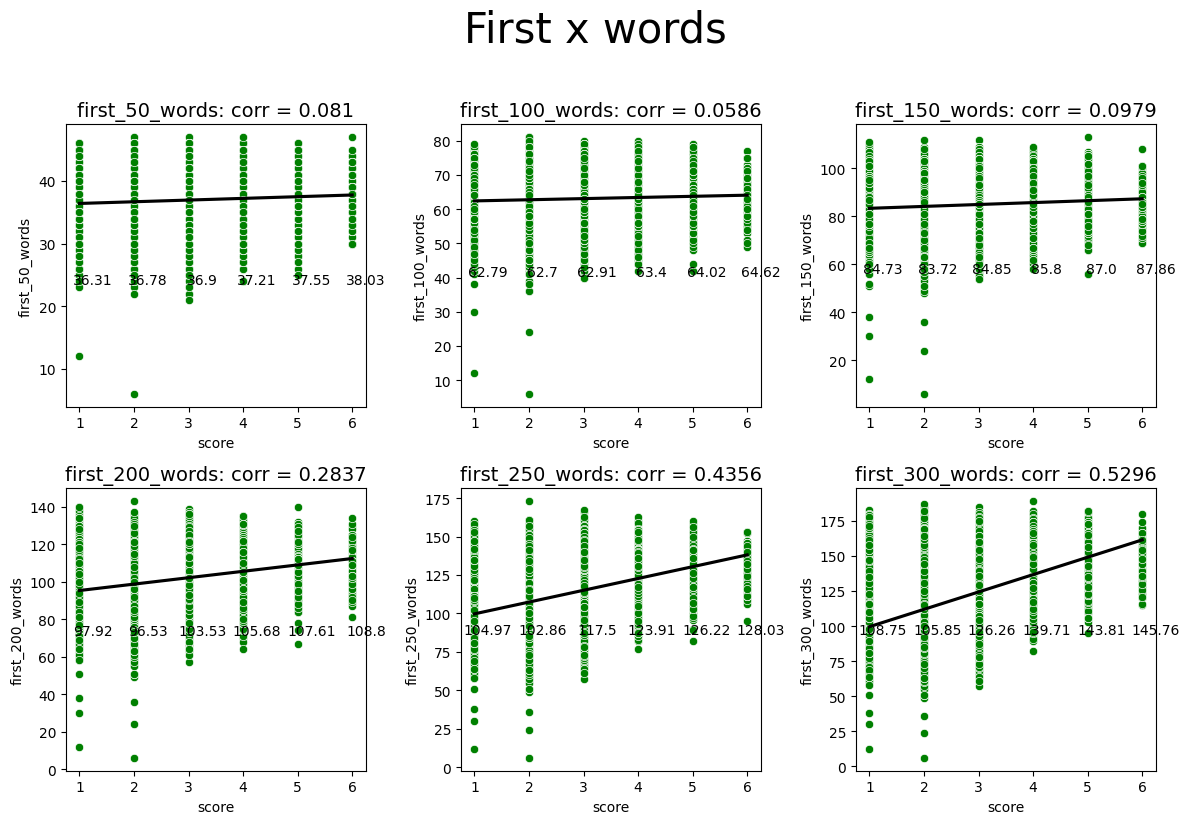

In [11]:
# uses a fixed number of words calculate the unique words ratio
def unique_words_fixed(text, range):

    # drops mispellings
    dropped_mispellings = drop_mispellings(text)

    # retains the first x words
    first_x_words = dropped_mispellings[0:range]

    # unique words
    unique_words_count = len(set(first_x_words))

    # unique words ratio
    unique_words_ratio = unique_words_count / len(text.split(' '))

    return unique_words_count
        

# creates a new feature for different values of first words 
names = []
ranges = ['50', '100', '150', '200', '250', '300']
for range in ranges:
    print('Working on range: ' + str(range))
    name = 'first_' + range + '_words'
    train[name] = [unique_words_fixed(x, range=eval(range)) for x in train['full_text']]
    names.append(name)


# examines the correlations
correlation_analysis(train, names, ncols=3, title='First x words')

## Re-examine multicollinearity

As we can see below, the new feature's correlation with total words is over twice as small (0.14) as before (0.38). This shows how you can deal with multicollinearity. In this case though, a correlation of 0.38 was not deemed high enough to be a problem and so the feature involving only dropped misspellings was used. 

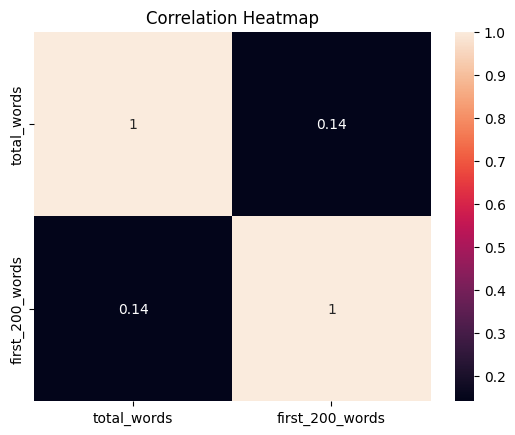

In [12]:
# correlation dataframe
corr_df = pd.DataFrame({'total_words': total_words,
                        'first_200_words': train['first_200_words']})

# matrix
correlation_matrix = corr_df.corr()


# heatmap
sns.heatmap(correlation_matrix, annot=True);
plt.title("Correlation Heatmap");
plt.show();